C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so infer


Final SARIMAX MAE: 9711.49 USD


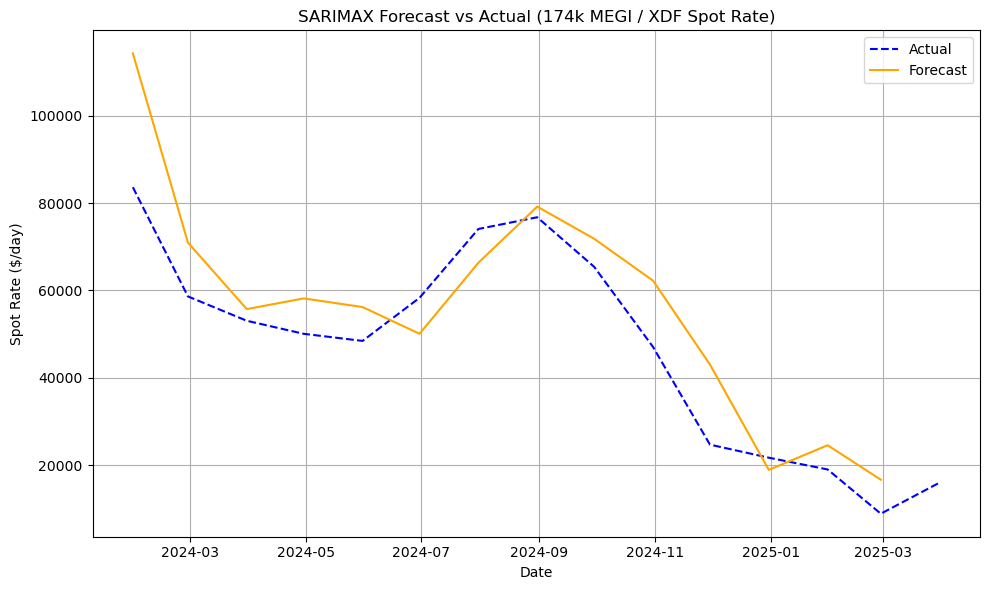

In [63]:
# SARIMAX model with seasonal component and exogenous variables
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

# === Load and prepare data ===
# Load spot rates
spot_file = "Spot charter rates - Fearnley LNG.xlsx"
xls = pd.ExcelFile(spot_file)
df_spot = xls.parse('Export')
df_spot['Date'] = pd.to_datetime(df_spot['Date'])
df_spot.set_index('Date', inplace=True)
monthly_rates = df_spot['174k MEGI / XDF'].resample('ME').mean()

# Load exogenous data
exog_file = "datatest.csv"
df_exog = pd.read_csv(exog_file)
df_exog['Date'] = pd.to_datetime(df_exog['Date'], format='%b-%y', errors='coerce')
df_exog = df_exog.dropna(subset=['Date'])
df_exog.set_index('Date', inplace=True)
df_exog.columns = [
    'Spot_145K_ST', 'Spot_174K_DF', 'Newbuilding_Price', 'Orderbook_CBM',
    'Ships_on_Order', 'Gas_Asia', 'Gas_EU', 'Gas_US',
    'Spread_EU_US', 'Spread_ASIA_US', 'Spread_ASIA_EU']
df_exog = df_exog.apply(pd.to_numeric, errors='coerce')
df_exog.index = df_exog.index.to_period('M').to_timestamp('M')

# Align exog with target
aligned_exog = df_exog.loc[monthly_rates.index.intersection(df_exog.index)]
exog_train = aligned_exog[aligned_exog.index < '2024-01-01']
exog_test = aligned_exog[aligned_exog.index >= '2024-01-01']

# === Prepare target variable ===
train = monthly_rates[monthly_rates.index < '2024-01-01']
test = monthly_rates[monthly_rates.index >= '2024-01-01']
train_vals = train[train > 0]
boxcox_transformed, lambda_bc = boxcox(train_vals.values)
train_boxcox = pd.Series(boxcox_transformed, index=train_vals.index)

# Exog variables to use
exog_vars = ['Spread_ASIA_US', 'Gas_US', 'Orderbook_CBM']
exog_train_sel = exog_train[exog_vars].loc[train_boxcox.index]
exog_test_sel = exog_test[exog_vars]

# Handle missing values (fill forward then backward)
exog_train_sel = exog_train_sel.ffill().bfill()
exog_test_sel = exog_test_sel.ffill().bfill()

# === Best SARIMAX params ===
order = (1, 1, 2)
seasonal_order = (1, 0, 1, 12)

# === Rolling forecast ===
preds = []
y_train = train_boxcox.copy()
X_train = exog_train_sel.copy()

for date in exog_test_sel.index:
    model = SARIMAX(y_train,
                    exog=X_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast = results.forecast(steps=1, exog=exog_test_sel.loc[[date]])
    pred = inv_boxcox(forecast.values[0], lambda_bc)
    preds.append(pred)

    # update training data
    if test[date] > 0:
        transformed = boxcox([test[date]], lmbda=lambda_bc)[0]
        y_train = pd.concat([y_train, pd.Series([transformed], index=[date])])
        X_train = pd.concat([X_train, exog_test_sel.loc[[date]]])
    else:
        preds.append(np.nan)

# === Evaluation and Visualization ===
pred_series = pd.Series(preds, index=exog_test_sel.index)
comparison = pd.concat([test, pred_series], axis=1).dropna()
mae = mean_absolute_error(comparison.iloc[:, 0], comparison.iloc[:, 1])
print(f"\nFinal SARIMAX MAE: {mae:.2f} USD")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='Actual', linestyle='--', color='blue')
plt.plot(pred_series.index, pred_series.values, label='Forecast', color='orange')
plt.title('SARIMAX Forecast vs Actual (174k MEGI / XDF Spot Rate)')
plt.xlabel('Date')
plt.ylabel('Spot Rate ($/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Eier\AppData\Local\Temp\ipykernel_47992\3842794750.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rates = spot_df.set_index("date")['174k MEGI / XDF'].resample('M').mean()
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood opti


Best SARIMAX Forecast:
MAE: $8,523
RMSE: $11,989


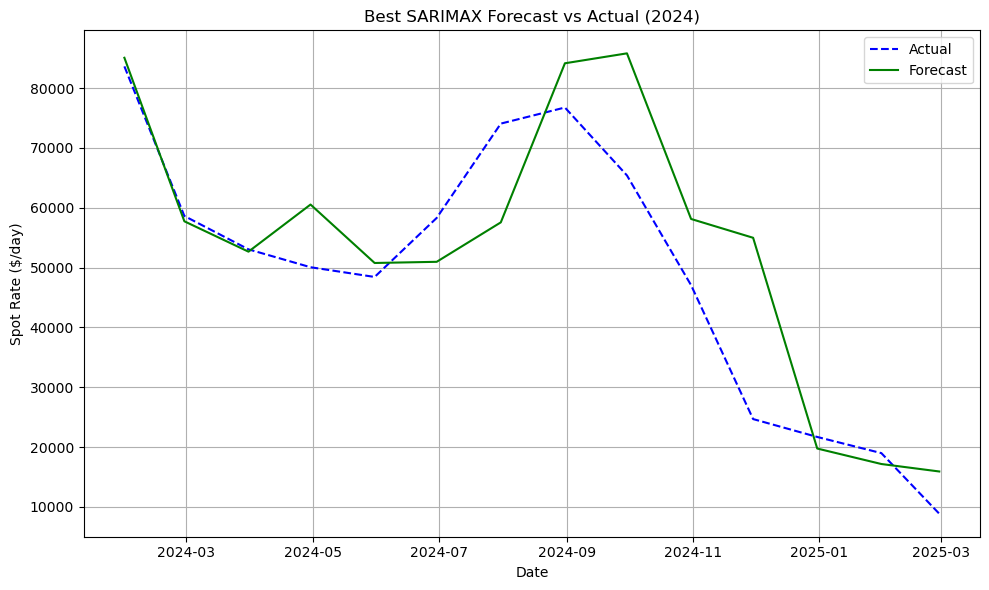

In [76]:
%No vessel variables
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

# === Load Spot Charter Rates ===
spot_df = pd.read_csv("Spot charter rates - Fearnley LNG csv.csv", delimiter=';', skipinitialspace=True)
spot_df.columns = [col.strip() for col in spot_df.columns]
spot_df = spot_df.rename(columns={"Date": "date"})
spot_df['date'] = pd.to_datetime(spot_df['date'], format="%d.%m.%Y")
spot_df['174k MEGI / XDF'] = (
    spot_df['174k MEGI / XDF'].astype(str)
    .str.replace(" ", "").str.replace(",", "").replace('', None).astype(float)
)
monthly_rates = spot_df.set_index("date")['174k MEGI / XDF'].resample('M').mean()

# === Load Exogenous Variables ===
exog_df = pd.read_csv("datatest_3.csv")
exog_df['Date'] = pd.to_datetime(exog_df['Date'], format="%b-%Y", errors='coerce')
exog_df = exog_df.dropna(subset=['Date'])
exog_df.set_index("Date", inplace=True)
exog_df.index = exog_df.index.to_period('M').to_timestamp('M')
exog_df.columns = [
    'Spot_145K_ST', 'Spot_174K_DF', 'LNG_Capacity', 'Newbuilding_Price',
    'Orderbook_CBM', 'Ships_on_Order', 'Gas_Asia', 'Gas_EU', 'Gas_US',
    'Spread_EU_US', 'Spread_ASIA_US', 'Spread_ASIA_EU'
]

# === Align Exogenous Data ===
selected_vars = ['LNG_Capacity', 'Orderbook_CBM', 'Spread_ASIA_US']
aligned_exog = exog_df[selected_vars].loc[monthly_rates.index.intersection(exog_df.index)]
exog_train = aligned_exog[aligned_exog.index < '2024-01-01'].ffill().bfill()
exog_test = aligned_exog[aligned_exog.index >= '2024-01-01'].ffill().bfill()

# === Prepare Target Variable ===
train = monthly_rates[monthly_rates.index < '2024-01-01']
test = monthly_rates[monthly_rates.index >= '2024-01-01']
train_vals = train[train > 0]
boxcox_transformed, lambda_bc = boxcox(train_vals.values)
train_boxcox = pd.Series(boxcox_transformed, index=train_vals.index)

# === Rolling SARIMAX Forecast ===
preds = []
y_train = train_boxcox.copy()
X_train = exog_train.loc[y_train.index]

for date in exog_test.index:
    model = SARIMAX(
        y_train, exog=X_train,
        order=(2, 1, 2), seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False, enforce_invertibility=False
    )
    results = model.fit(disp=False)
    forecast = results.forecast(steps=1, exog=exog_test.loc[[date]])
    pred = inv_boxcox(forecast.values[0], lambda_bc)
    preds.append(pred)

    # Update training set with true data
    if test[date] > 0:
        transformed = boxcox([test[date]], lmbda=lambda_bc)[0]
        y_train = pd.concat([y_train, pd.Series([transformed], index=[date])])
        X_train = pd.concat([X_train, exog_test.loc[[date]]])

# === Evaluate Forecast ===
forecast_series = pd.Series(preds, index=exog_test.index)
comparison = pd.concat([test, forecast_series], axis=1).dropna()
comparison.columns = ['Actual', 'Forecast']
mae = mean_absolute_error(comparison['Actual'], comparison['Forecast'])
rmse = mean_squared_error(comparison['Actual'], comparison['Forecast'], squared=False)

print(f"\nBest SARIMAX Forecast:")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")

# === Plot Forecast ===
plt.figure(figsize=(10, 6))
plt.plot(comparison.index, comparison['Actual'], label='Actual', linestyle='--', color='blue')
plt.plot(comparison.index, comparison['Forecast'], label='Forecast', color='green')
plt.title('Best SARIMAX Forecast vs Actual (2024)')
plt.xlabel('Date')
plt.ylabel('Spot Rate ($/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
